In [473]:
import numpy as np
import torch

import matplotlib.pylab as plt
from pylightcurve_torch import TransitModule

### Prepare data

In [474]:
time_tensor =  torch.linspace(0,10,500)
pars =  {'e':0.01, 'i':89., 'w':1., 'rp': 0.05, 'method': 'linear', 'ldc': [0.08], 
         'P': 50., 't0': 5., 'a': 5., 'fp': 0.0001}

module = TransitModule(time=time_tensor, **pars)

data = module() + torch.normal(0, 1e-4, time_tensor.shape)

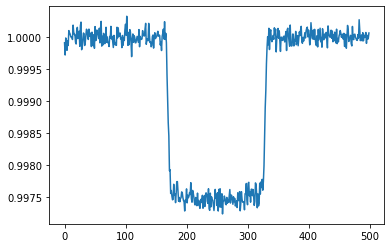

In [475]:
plt.plot(data.T)

# Pyro Model and Guide

In [476]:
import pyro 
import pyro.distributions as dist

def model(flux=None):
    rp_over_rs = pyro.sample("rp_over_rs", dist.Uniform(0., 1))
    mid_time = pyro.sample("mid_time", dist.Uniform(4.5, 5.5))
#     inclination = pyro.sample('inclination', dist.Uniform(85, 90.))

    sigma = pyro.sample("sigma", dist.Uniform(0.,0.001))
    
#     rp_over_rs = pyro.sample("rp_over_rs", dist.Normal(0.049, 0.001))
#     mid_time = pyro.sample("mid_time", dist.Normal(5.1, 0.1))
#     inclination = pyro.sample('inclination', dist.Normal(88.5, 0.05))
#     sigma = pyro.sample("sigma", dist.Normal(0.0001,0.00001))
    
    mean_flux = module.forward(rp_over_rs=rp_over_rs, mid_time=mid_time) #inclination=inclination)  ### * F0
    mean_flux[torch.isnan(mean_flux)] = 0.
    
    with pyro.plate('data', flux.shape[-1]):
        try:
            pred_flux = pyro.sample('obs', dist.Normal(mean_flux, sigma), obs=flux)  #### Check
        except ValueError as e:
            print(rp_over_rs)
#             print(inclination)
            print(mid_time)
            print(mean_flux)
            raise e

## HMC

In [477]:
from pyro.infer import MCMC, NUTS


nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=300)
mcmc.run(data)



Warmup:   2%|▏         | 28/1300 [00:04,  3.77it/s, step size=1.71e-03, acc. prob=0.795]

KeyboardInterrupt: 

In [478]:
variables  = ['rp_over_rs', 'mid_time', 'sigma']

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

AttributeError: 'NoneType' object has no attribute 'items'

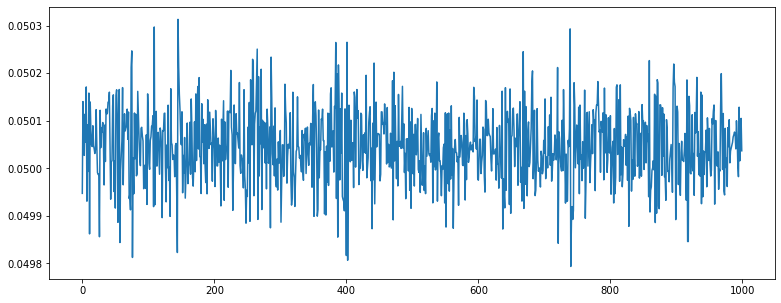

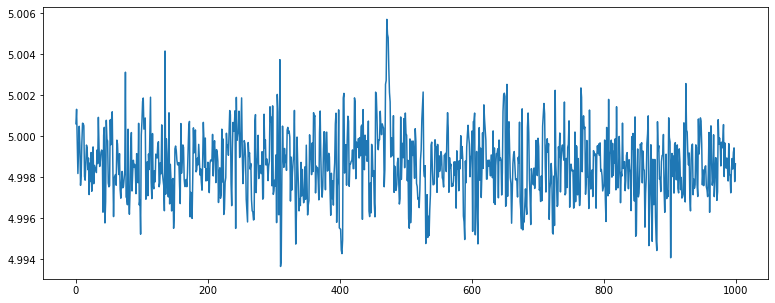

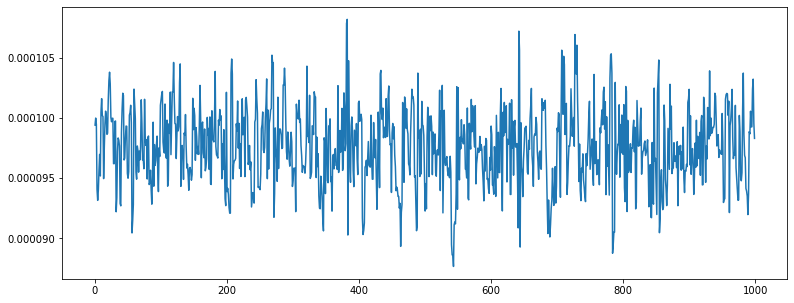

In [414]:
# Show traces
for variable in variables:
    plt.figure(figsize=(13,5))
    plt.plot(hmc_samples[variable])
    plt.show()


# Define a guide for approximate inference

In [449]:
import pyro.distributions.constraints as constraints
    
def guide(flux=None):
    loc_rp = pyro.param('loc_rp', torch.tensor(0.06),
                             constraint=constraints.interval(0.,1.))
    scale_rp = pyro.param('scale_rp', torch.tensor(0.001),
                           constraint=constraints.positive)  
    
    loc_mt = pyro.param('loc_mt', torch.tensor(5.1),
                             constraint=constraints.interval(4., 6.))
    scale_mt = pyro.param('scale_mt', torch.tensor(0.1),
                           constraint=constraints.positive) 

#     loc_i = pyro.param('loc_i', torch.tensor(88.5),
#                              constraint=constraints.interval(87., 89.9))
#     scale_i = pyro.param('scale_i', torch.tensor(0.001),
#                           constraint=constraints.interval(0, 0.05))
    
    loc_sigma = pyro.param('loc_sigma', torch.tensor(0.00015),
                             constraint=constraints.interval(0.00001,0.0008))
    scale_sigma = pyro.param('scale_sigma', torch.tensor(0.00005),
                             constraint=constraints.interval(0.000001,0.0005)) 
    
#     min_rp = pyro.param('min_rp', torch.tensor(0.04),
#                              constraint=constraints.positive)
#     max_rp = pyro.param('max_rp', torch.tensor(0.06),
#                            constraint=constraints.positive)  
    
    
#     min_mt = pyro.param('min_mt', torch.tensor(4.5),
#                          constraint=constraints.interval(4., 6.))
#     max_mt = pyro.param('max_mt', torch.tensor(5.5),
#                         constraint=constraints.interval(4., 6.))
    
#     max_sigma = pyro.param('max_sigma', torch.tensor(0.0005), 
#                            constraint=constraints.interval(0.,0.001))  

    
    rp_over_rs = pyro.sample('rp_over_rs', dist.Normal(loc_rp, scale_rp))
#     inclination = pyro.sample('inclination', dist.Normal(loc_i, scale_i))
    mid_time = pyro.sample('mid_time', dist.Normal(loc_mt, scale_mt))
    sigma = pyro.sample("sigma", dist.Normal(loc_sigma, scale_sigma))
    
#     rp_over_rs = pyro.sample("rp_over_rs", dist.Uniform(min_rp, max_rp))
#     mid_time = pyro.sample("mid_time", dist.Uniform(min_mt, max_mt))
#     sigma = pyro.sample("sigma", dist.Uniform(0., max_sigma))

    pred_flux = module.forward(rp_over_rs=rp_over_rs, mid_time=mid_time)
    
#     pred_flux = pyro.sample('obs', dist.Normal(pred_flux, sigma))

In [458]:
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, init_to_median

guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
guide = AutoDiagonalNormal(model)

# SVI

In [459]:
import logging
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO


svi = SVI(model,
          guide,
          optim.Adam({"lr": 0.5}),
          loss=Trace_ELBO())

pyro.clear_param_store()
num_iters = 1000
for i in range(num_iters):
    elbo = svi.step(data)
    if i % 50 == 0:
        print("Elbo loss: {}".format(elbo))


Elbo loss: 14701609.957202759
Elbo loss: -2561.381712846216
Elbo loss: -2575.4985201570025
Elbo loss: -2563.2524871605274
Elbo loss: -2560.2663530860013
Elbo loss: -2577.057461590395
Elbo loss: -2565.0865470168383
Elbo loss: -2571.7195780599127
Elbo loss: -2567.141059521109
Elbo loss: -2568.9671451492313
Elbo loss: -2574.621040932522
Elbo loss: -2567.387642972989
Elbo loss: -2567.590490475321
Elbo loss: -2568.1612622047933
Elbo loss: -2576.158944536795
Elbo loss: -2582.4915637576423
Elbo loss: -2585.037063530031
Elbo loss: -2588.4315719954975
Elbo loss: -2564.4130930402234
Elbo loss: -2591.2237188846784


In [465]:
num_iters = 3000
for i in range(num_iters):
    elbo = svi.step(data)
    if i % 50 == 0:
        print("Elbo loss: {}".format(elbo))


Elbo loss: -2579.4146159009597
Elbo loss: -2599.6505470985385
Elbo loss: -2585.1317944320376
Elbo loss: -2578.204726766221
Elbo loss: -2589.344286075431
Elbo loss: -2589.1438601538794
Elbo loss: -2606.5996899609395
Elbo loss: -2588.152971252357
Elbo loss: -2604.6964554722786
Elbo loss: -2589.7380471412735
Elbo loss: -2592.8642234638714
Elbo loss: -2591.770013236307
Elbo loss: -2604.0373309154784
Elbo loss: -2625.292819916828
Elbo loss: -2606.643852774117
Elbo loss: -2608.2325270068613
Elbo loss: -2622.029434974942
Elbo loss: -2629.599823062863
Elbo loss: -2619.028345298991
Elbo loss: -2616.217499044676
Elbo loss: -2633.961136245539
Elbo loss: -2626.4084746895933
Elbo loss: -2622.0045721696574
Elbo loss: -2631.185728836584
Elbo loss: -2629.8778606437327
Elbo loss: -2670.236932017916
Elbo loss: -2680.251648491302
Elbo loss: -2689.5054743750657
Elbo loss: -2674.3639807930645
Elbo loss: -2666.391193731451
Elbo loss: -2671.5192297875533
Elbo loss: -2685.455071682246
Elbo loss: -2693.3586765

In [466]:
from pyro.infer import Predictive


num_samples = 100
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(data).items()
               if k != "obs"}


/Users/mario/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mario/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mario/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

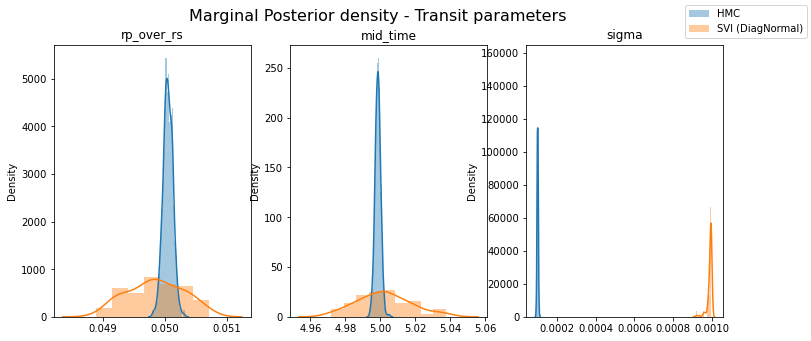

In [470]:
import seaborn as sns
fig, axs = plt.subplots(ncols=len(variables), figsize=(12, 5))

fig.suptitle("Marginal Posterior density - Transit parameters", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    variable = variables[i]
    sns.distplot(hmc_samples[variable], ax=ax, label="HMC")
    sns.distplot(svi_samples[variable], ax=ax, label="SVI (DiagNormal)")
    ax.set_title(variable)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

In [471]:
par1, par2 = variables[0], variables[1]

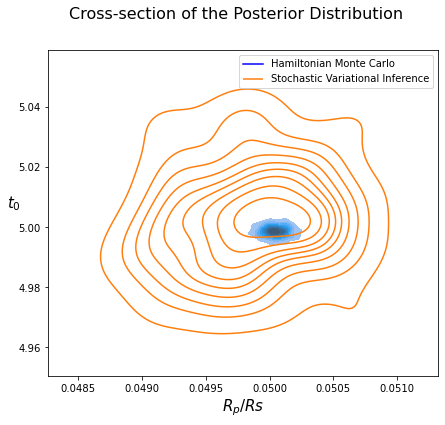

In [472]:
fig, ax = plt.subplots(figsize=(7, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=hmc_samples[par1], y=hmc_samples[par2], ax=ax, shade=True)
# ax.set(xlabel=par1, ylabel=par2, xlim=(0.0497, 0.0503), ylim=(88.96, 89.03))
plt.plot([], color='blue', label="Hamiltonian Monte Carlo")
sns.kdeplot(x=svi_samples[par1], y=svi_samples[par2], ax=ax, label="Stochastic Variational Inference")
# ax.hlines(89, *ax.get_xlim(), color='red', alpha=0.7, ls='dashed', '')
# ax.vlines(0.05, *ax.get_ylim(), color='red', alpha=0.7, ls='dashed')
ax.set_xlabel('$R_p/Rs$', fontsize=15)
ax.set_ylabel('$t_0$', fontsize=15, rotation=0)
ax.legend()
# plt.show()

In [424]:
x = ax.get_legend_handles_labels()[0][0]

In [ ]:
x.